Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

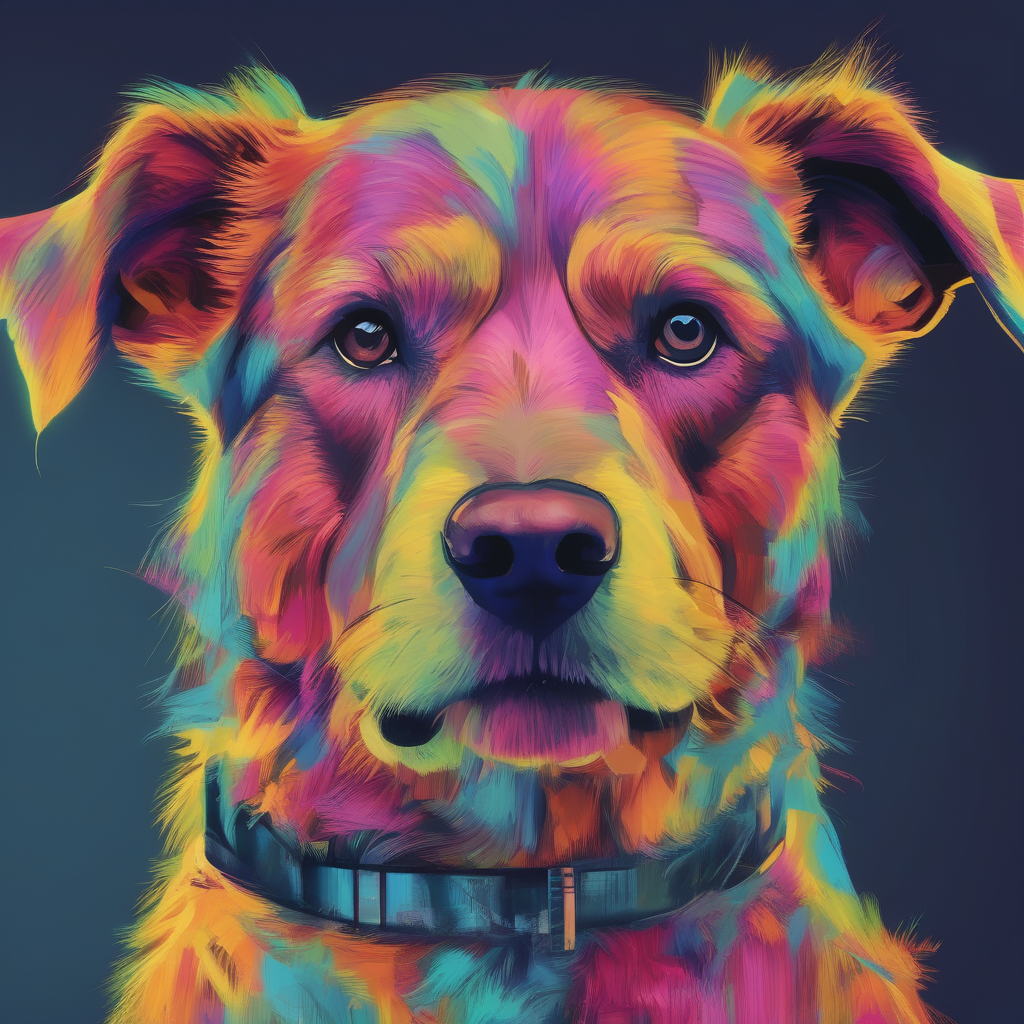

In [1]:
import torch
from diffusers import DiffusionPipeline


pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

gen = torch.Generator().manual_seed(42)
pipe("a colorful, movie like photo of dog", generator=gen).images[0]

In [6]:
# in the future, you use the unet safetensor
from safetensors.torch import save_file, load_file

save_file(pipe.unet.state_dict(), "unet.safetensors")


In [1]:
import torch
from diffusers import  UNet2DConditionModel

# switch UNet for another model
#unet = UNet2DConditionModel.from_pretrained(
#    "stabilityai/stable-diffusion-xl-base-1.0",
#    subfolder="unet",
#    torch_dtype=torch.float16,
#    variant="fp16",
#    use_safetensors=True
#).to("cuda")

#print(unet)
# empty cache
#torch.cuda.empty_cache()

import torch
from diffusers import UNet2DConditionModel

# Загрузка предобученной модели UNet2DConditionModel
unet = UNet2DConditionModel.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    subfolder="unet",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

# Вывод всех параметров модели
print(unet.config)

# Изменение одного из параметров
# Например, изменение количества каналов выходного слоя
unet.config["out_channels"] = 8  # Предположим, что мы хотим установить новое значение

# Обновление архитектуры модели на основе новых параметров
# Это может потребовать пересоздания модели или модификации существующей
# В данном случае мы создадим новую модель с обновленными параметрами
new_unet = UNet2DConditionModel(**unet.config)

# Сохранение модели в формате diffusers
save_directory = "/home/recoilme/models/custom_unet"
new_unet.save_pretrained(save_directory, safe_serialization=True)

print(f"Модель успешно сохранена в {save_directory}")

print(unet)

FrozenDict([('sample_size', 128), ('in_channels', 4), ('out_channels', 4), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']), ('mid_block_type', 'UNetMidBlock2DCrossAttn'), ('up_block_types', ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [320, 640, 1280]), ('layers_per_block', 2), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('dropout', 0.0), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', 2048), ('transformer_layers_per_block', [1, 2, 10]), ('reverse_transformer_layers_per_block', None), ('encoder_hid_dim', None), ('encoder_hid_dim_type', None), ('attention_head_dim', [5, 10, 20]), ('num_attention_heads', None), ('dual_cross_attention', False), ('use_linear_projection', True), ('class_embed_type', None), ('addition_embed_type', 'text_time'), ('additi

In [5]:

from safetensors.torch import save_file, load_file

save_file(pipe.unet.state_dict(), "unet.safetensors")

NameError: name 'pipe' is not defined

: 

In [1]:
from safetensors.torch import load_file
import torch
from sdxl_rewrite import UNet2DConditionModel

from diffusers.models.modeling_utils import ModelMixin

# You need to do this to imitate the diffuser's ModelMixin behavior


class hfdiff(UNet2DConditionModel, ModelMixin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        pass


tensors = load_file("unet.safetensors")
with torch.device("cuda"):
    with torch.cuda.amp.autocast():
        unet_new = hfdiff().half()
        unet_new.load_state_dict(tensors)

unet_new.eval()

/tmp/ipykernel_41956/65055258.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


hfdiff(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (add_time_proj): Timesteps()
  (add_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=2816, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv1): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=1280, out_features=320, bias=True)
          (norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=F

Expected types for unet: ['UNet2DConditionModel'], got hfdiff.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

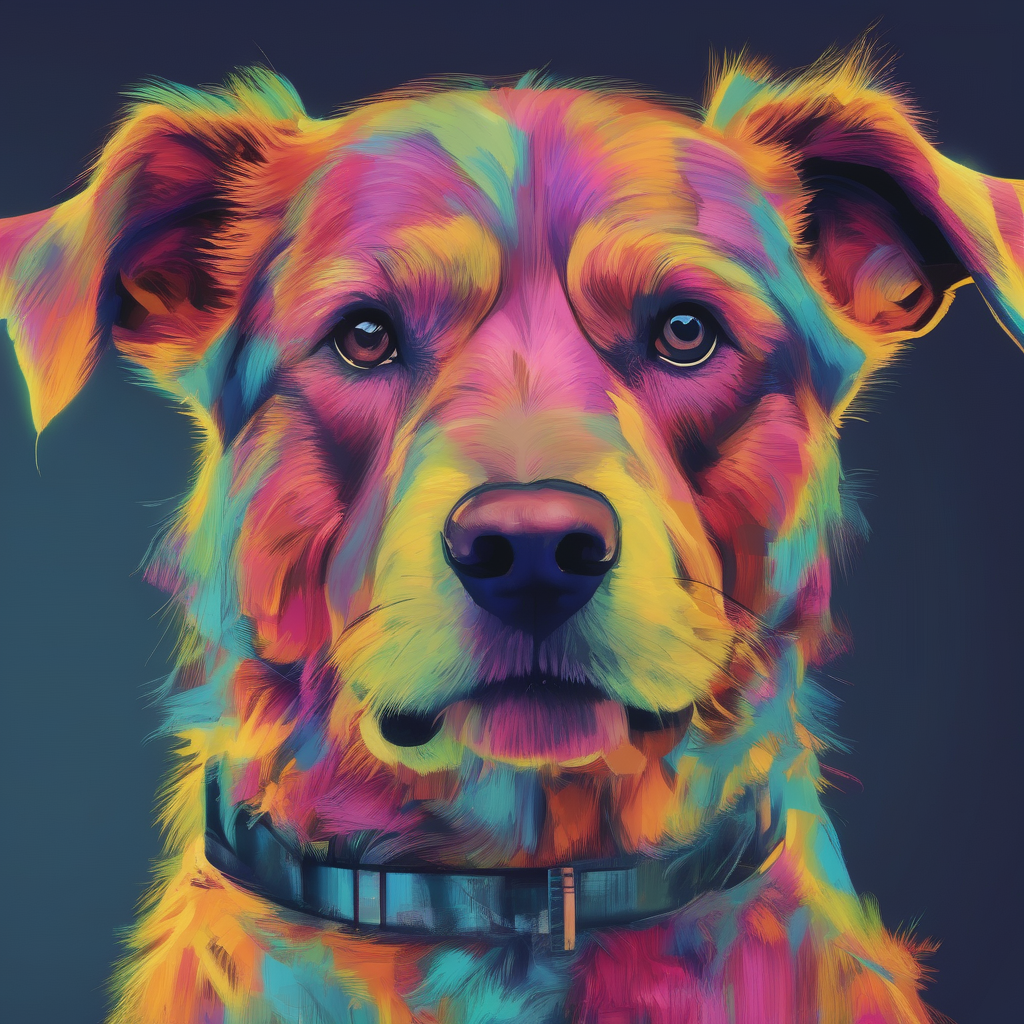

In [2]:
from diffusers import DiffusionPipeline


pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    unet=new_unet,#unet_new,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")
gen = torch.Generator().manual_seed(42)
pipe("a colorful, movie like photo of dog", generator=gen).images[0]

print(new_unet.config)